In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets,transforms
from torch.utils.data import DataLoader,random_split
import torch.nn as nn
import gc

In [2]:
os.chdir("../")

In [50]:
# ===========================
# 1️⃣ Define your transformations
# ===========================
transform = transforms.Compose([
    transforms.Resize((224, 224)),                     # Resize images
    transforms.RandomHorizontalFlip(p=0.5),            # Randomly flip images
    transforms.RandomRotation(degrees=15),             # Random rotation
    transforms.ToTensor(),                             # Convert to tensor [C, H, W] in [0, 1]
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# ===========================
# 2️⃣ Safe Dataset Loader
# ===========================
class SafeImageFolder(datasets.ImageFolder):
    def __getitem__(self, index):
        try:
            return super().__getitem__(index)
        except (FileNotFoundError, OSError):
            # Skip the missing/corrupt image by picking another index
            new_index = (index + 1) % len(self)
            print(f"⚠️ Skipping broken image at index {index}")
            return self.__getitem__(new_index)

# ===========================
# 3️⃣ Load the full dataset safely
# ===========================
dataset = SafeImageFolder(root="data/image_dataset/road_image_dataset", transform=transform)

# ===========================
# 4️⃣ Split dataset into train & test
# ===========================
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# ===========================
# 5️⃣ Create DataLoaders
# ===========================
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"✅ Dataset loaded successfully: {len(train_dataset)} train samples, {len(test_dataset)} test samples")



✅ Dataset loaded successfully: 32000 train samples, 8000 test samples


In [51]:
image, label = dataset[0]

In [52]:
image.shape

torch.Size([3, 224, 224])

In [53]:
X,y = next(iter(test_loader))

In [54]:
X.shape

torch.Size([32, 3, 224, 224])

In [55]:
dataset.classes

['Negative', 'Positive']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.003921628].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.7882353].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.92156863].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.7882353].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.27843142].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.7882353].
Clipping input data to the va

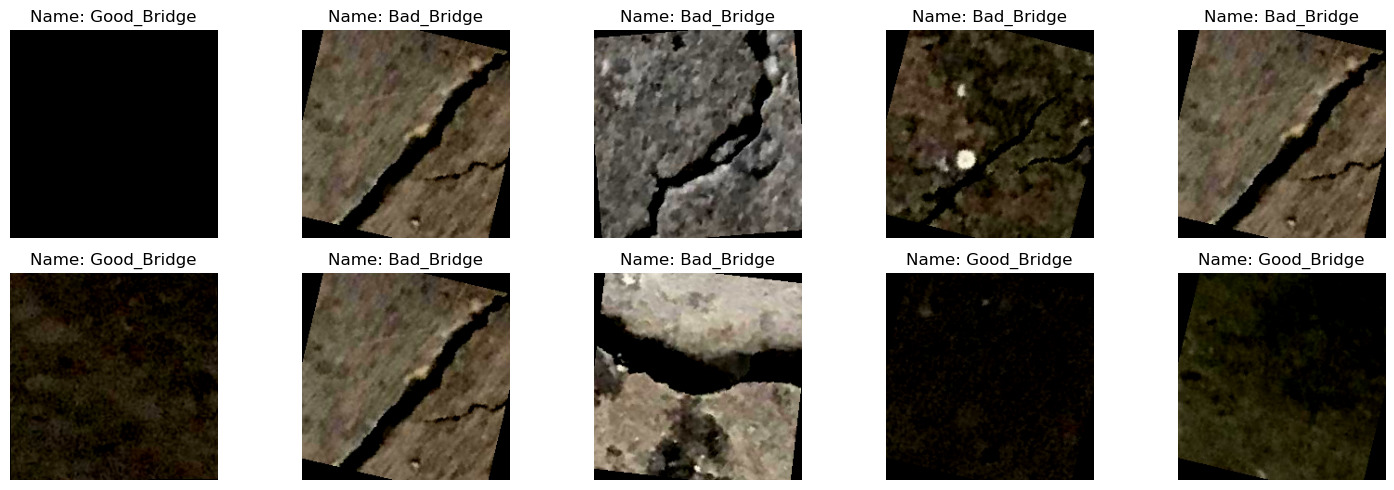

In [56]:
fig,axsex = plt.subplots(2,5,figsize=(15,5))

for ax in axsex.flatten():
    img_num = np.random.choice(range(0,len(X)))
    ax.imshow(X[img_num,].permute(1,2,0))
    label = "Good_Bridge" if y[img_num] == 0 else "Bad_Bridge"
    ax.set_title(f"Name: {label}")
    ax.axis("off")

plt.tight_layout() 

## bUILDING CNN MODEL

In [57]:
def get_model_optimizer():
    net = ResNetLike(num_classes=1)
    lossFun = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    return net, optimizer, lossFun

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        if self.downsample:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNetLike(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 2)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = [BasicBlock(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(BasicBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))  # [B, 64, H/2, W/2]
        x = self.pool(x)                        # [B, 64, H/4, W/4]
        x = self.layer1(x)                      # -> [B, 64, H/4, W/4]
        x = self.layer2(x)                      # -> [B, 128, H/8, W/8]
        x = self.layer3(x)                      # -> [B, 256, H/16, W/16]
        x = self.layer4(x)                      # -> [B, 512, H/32, W/32]
        x = self.global_pool(x)                 # -> [B, 512, 1, 1]
        x = torch.flatten(x, 1)                 # -> [B, 512]
        x = self.fc(x)  # Logits

        return x

In [58]:
net, optimizer, lossFun = get_model_optimizer()

In [59]:
x,y = next(iter(train_loader))
y

tensor([0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
        1, 1, 0, 1, 0, 0, 1, 1])

In [60]:
lossFun(net(x).squeeze(),y.float())

tensor(0.8143, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [61]:
def train_model(train_loader, device, val_loader):
    torch.cuda.empty_cache()
    gc.collect()

    # Make sure this returns model, optimizer, and loss function
    net, optimizer, lossFun = get_model_optimizer()
    net.to(device)

    num_epochs = 1
    accumulation_steps = 16

    train_acc = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)

    for epoch in range(num_epochs):
        net.train()
        optimizer.zero_grad()

        epoch_train_losses = []
        epoch_train_acc = []

        for i, (X, y) in enumerate(train_loader):
            X = X.to(device)
            y = y.to(device).float().unsqueeze(1)  #  Ensure shape (batch, 1)

            # ---- Forward Pass ----
            y_pred = net(X)

            # ---- Compute Loss ----
            loss = lossFun(y_pred, y)
            loss = loss / accumulation_steps  # gradient accumulation
            loss.backward()

            # ---- Accuracy ----
            preds = (y_pred >= 0.5).float()
            acc = (preds == y).float().mean().item()
            epoch_train_acc.append(acc)
            epoch_train_losses.append(loss.item() * accumulation_steps)

            # ---- Step Optimizer ----
            if (i + 1) % accumulation_steps == 0 or (i + 1) == len(train_loader):
                optimizer.step()
                optimizer.zero_grad()

        # ---- Log Training Results ----
        train_loss[epoch] = np.mean(epoch_train_losses)
        train_acc[epoch] = np.mean(epoch_train_acc)

        # ============================
        # 🔍 Evaluation
        # ============================
        net.eval()
        val_losses = []
        val_accuracies = []

        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val = X_val.to(device)
                y_val = y_val.to(device).float().unsqueeze(1)

                y_pred = net(X_val)
                val_loss_value = lossFun(y_pred, y_val).item()

                preds = (y_pred >= 0.5).float()
                acc = (preds == y_val).float().mean().item()

                val_losses.append(val_loss_value)
                val_accuracies.append(acc)

        val_loss[epoch] = np.mean(val_losses)
        val_acc[epoch] = np.mean(val_accuracies)

        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {train_loss[epoch]:.4f}, Train Acc: {train_acc[epoch]:.4f} | "
              f"Val Loss: {val_loss[epoch]:.4f}, Val Acc: {val_acc[epoch]:.4f}")

        torch.cuda.empty_cache()
        gc.collect()

    return train_loss, train_acc, val_loss, val_acc, net


In [62]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [63]:
train_loss, train_acc, test_loss, test_acc, net = train_model(train_loader,device,test_loader)

Epoch [1/1] | Train Loss: 0.1479, Train Acc: 0.9553 | Val Loss: 0.0291, Val Acc: 0.9904


In [64]:
# Save the trained model
torch.save(net.state_dict(), "notebooks/trained_model/brigded_image_model.pth")
print("Model saved to notebooks/trained_model/brigded_model.pth")

Model saved to notebooks/trained_model/brigded_model.pth
